In [28]:
WEB_SITE_matrix = './chetor.com/view_matrix/lil_matrix.npz'
WEB_SITE_itemindexer = './chetor.com/view_matrix/item_indexer.indexer'
WEB_SITE_userindexer = './chetor.com/view_matrix/user_indexer.indexer'
SAVING1 = './chetor.com/alisResult/ALS/ali_item_indexer_factorized.indexer'
SAVING2 = './chetor.com/alisResult/ALS/ali_user_indexer_factorized.indexer'
SAVING3 = './chetor.com/alisResult/ALS/ali_items_vectors.npy'
SAVING4 = './chetor.com/alisResult/ALS/ali_users_vectors.npy'
WEB_SITE_NAME = 'Chetor.com'
RESULTS = '/home/yektanet/Pictures/ALSOpt/'
TEST_SET_SIZE = 0.09 # max = 1
TEST_SET_SIZE1 = 0.02 # max = 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math
from sklearn.model_selection import train_test_split
# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix
import scipy
import scipy.sparse
import itertools
import random

In [3]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load(WEB_SITE_itemindexer)
        self.user_indexer = AppendIndexer.load(WEB_SITE_userindexer)
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

In [4]:
def ALSReady(path: str, l = 2):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = l, 
                      item_min_view = l)
    implicit_matrix = matrix.to_csr()
    print('matrix has been made dense in', time.time() - now, 'seconds.')
    return matrix, sparce_matrix, implicit_matrix

def CFTrain(matrix, implicit_matrix, _alpha = 15, _facs = 20, _itr = 15, save = False):
    
    now = time.time()
    als_model = ALS.Als(num_factors = _facs,
                        iterations = _itr,
                        num_threads = 10,
                        alpha = _alpha)

    
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', alsTime, 'seconds.')
    if save:
        print('Saving Data ...')
        matrix.item_indexer.dump(SAVING1)
        matrix.user_indexer.dump(SAVING2)
        np.save(SAVING3, als_model.item_vectors)
        np.save(SAVING4, als_model.user_vectors)

    return als_model.item_vectors, als_model.user_vectors, alsTime

In [5]:
def get_annoy_results(pages_vector, number_of_trees = 50, number_of_neighbours = 11):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

implicit matrix ro migire va ye bakhshisho baramun test o train mikone ke ye bakhshi az cell ha sefr shodan:

In [6]:
def generate_test_set_precision_recall(implicit_matrix, _test_size = 0.05, test_cells = 0.2):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = _test_size)
    print('test_shape', test.shape, 'train_shape (which we cant process bc of RAM)', train.shape)
    rows,cols = test.nonzero()
    delete_index = [(rows[i], cols[i]) for i in random.sample(range(1, len(rows)), int(len(rows)*test_cells))]
    print("total cells", len(rows), "number of deleted cells", len(delete_index))
    
    x_train = scipy.sparse.csr_matrix(test.shape)
    for i, j in tqdm(zip(rows, cols)):
        if (i, j) in delete_index:
            continue
        x_train[i, j] = test[i, j]
    return x_train, test, delete_index

def prepare_data_for_AP(implicit_matrix, _test_size = 0.05):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = _test_size)
    print('test_shape', test.shape, 'train_shape (which we cant process bc of RAM)', train.shape)
    rows, cols = test.nonzero()
    unique, counts = np.unique(rows, return_counts=True)
    commulative_count = [0]
    for i in counts:
        commulative_count.append(commulative_count[-1] + i)
    delete_row = []
    for i in range(1, len(commulative_count)):
        delete_row.append(np.random.randint(commulative_count[i-1], commulative_count[i]))
    delete_index = [(rows[i], cols[i]) for i in delete_row]
    # print(delete_row[:10], delete_index[:10], rows[:10], cols[:10], random.randrange(commulative_count[0], 10, 2) )
    print("total cells", len(rows), "number of deleted cells", len(delete_index))
    
    x_train = scipy.sparse.csr_matrix(test.shape)
    for i, j in zip(rows, cols):
        if (i, j) in delete_index:
            continue
        x_train[i, j] = test[i, j]
    return x_train, test, delete_index

def prepare_data_for_MAE(implicit_matrix, set_size = 0.05):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = set_size)
    return test

In [7]:
def hit_rate_at_k(deleted, x_train, test_approx, k = 10):
    found = []
    for i in tqdm(range(len(test_approx))):
        ta = list(n_argmax(test_approx[i], 30))
        nonz = np.nonzero(x_train[i])[0]
        same_old = []
        for l in range(len(ta)):
            if ta[l] in nonz:
                same_old.append(l)

        for l in same_old[::-1]:
            ta.pop(l)
        ta = ta[:k]        
        for j in ta:
            found.append((i, j))
    same = 0
    a = np.array([hash(i) for i in found])
    b = np.array([hash(i) for i in deleted])
    same = np.sum(np.isin(b,a))
    print(same, len(deleted), same/len(deleted))
    return same/len(deleted)

def visited_at_k(x_train, test_approx, k = 10):
    same_old = []
    for i in tqdm(range(len(test_approx))):
        ta = list(n_argmax(test_approx[i], k))
        nonz = np.nonzero(x_train[i])[0]
        for l in range(len(ta)):
            if ta[l] in nonz:
                same_old.append(l)
    rows,cols = x_train.nonzero()
    return len(same_old)/len(rows)

def n_argmax(a, n):
    ranked = np.argsort(a)
    largest_indices = ranked[::-1][:n]
    return largest_indices

In [25]:
#random search
itrs1 = [15, 15, 15, 15, 15, 15]
alphas1 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
factors1 = [5, 10, 20, 40, 60, 100]

itrs2 = [15, 15, 15, 15, 15, 15]
alphas2 = [10, 10, 10, 10, 10, 10]
factors2 = [5, 10, 20, 40, 60, 100]

itrs3 = [15, 15, 15, 15, 15, 15]
alphas3 = [100, 100, 100, 100, 100, 100]
factors3 = [5, 10, 20, 40, 60, 100]

itrs4 = [15, 15, 15, 15, 15, 15]
alphas4 = [1000, 1000, 1000, 1000, 1000, 1000]
factors4 = [5, 10, 20, 40, 60, 100]

itrs = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
alphas = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10, 10, 10, 10, 10, 10, 100, 100, 100, 100, 100, 100, 1000, 1000, 1000, 1000, 1000, 1000]
factors = [5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100]

### metrics

accuracy metrics:
- recall@k, hit_rate@k
- visited_rate@k
- MAE on train set per iteration

time metrics:
- training time
- query time

In [9]:
def calc_visited_hitRate(alphas, itrs, factors, _l = 2, data_set_size = 0.072, log = False):
    visited3s = []
    hitRate3s = []
    visited6s = []
    hitRate6s = []
    AP3s = []
    AP6s = []
    trainingTime = []
    qTime = []
    matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=_l)
    x_train_AP, test_AP, delete_index_AP = prepare_data_for_AP(implicit_matrix, _test_size = data_set_size)
    x_train, test, deleted = generate_test_set_precision_recall(implicit_matrix, _test_size = data_set_size)
    for a,i,f in zip(alphas, itrs, factors):
        if log: print('------alphas, itrs, factors------', a,i,f)
        item_vectors, user_vectors, alsTime = \
        CFTrain(None, x_train, _alpha = a, _facs = f, _itr = i)
        a1, a2, duration = get_annoy_results(item_vectors)
        qTime.append(duration)
        trainingTime.append(alsTime)
        if log: print('training and querry time:', trainingTime[-1], qTime[-1])
        test_approx = np.matmul(user_vectors, item_vectors.T)
        visited3s.append(visited_at_k(x_train.toarray(), test_approx, k = 3))
        if log: print('visited3s', visited3s[-1])
        visited6s.append(visited_at_k(x_train.toarray(), test_approx, k = 6))
        if log: print('visited6s', visited6s[-1])
        hitRate3s.append(hit_rate_at_k(deleted, x_train.toarray(), test_approx, k = 3))
        if log: print('hitRate3s', hitRate3s[-1])
        hitRate6s.append(hit_rate_at_k(deleted, x_train.toarray(), test_approx, k = 6))
        if log: print('hitRate6s', hitRate6s[-1])
        item_vectors_AP, user_vectors_AP, alsTime_AP = \
        CFTrain(None, x_train_AP, _alpha = a, _facs = f, _itr = i)
        test_approx_AP = np.matmul(user_vectors_AP, item_vectors_AP.T)
        AP3s.append(hit_rate_at_k(delete_index_AP, x_train_AP, test_approx_AP, k = 3))
        if log: print('AP3s', AP3s[-1])
        AP6s.append(hit_rate_at_k(delete_index_AP, x_train_AP, test_approx_AP, k = 6))
        if log: print('AP6s', AP6s[-1])
    return visited3s, visited6s, hitRate3s, hitRate6s, AP3s, AP6s, trainingTime, qTime

In [10]:
def calc_mse__(alphas, itrs, factors, _l = 3, data_set_size = 0.072, log = False):
    mse = []
    matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=_l)
    train, test = train_test_split(implicit_matrix, shuffle=False, train_size = 0.06)
    for a,i,f in zip(alphas, itrs, factors):
        if log: print('------alphas, itrs, factors:', a,i,f, '------')
        item_vectors, user_vectors, alsTime = \
        CFTrain(None, train, _alpha = a, _facs = f, _itr = i)
        test_approx = np.matmul(user_vectors, item_vectors.T)
        mse.append(MSE(test_approx, train))
        print('MSE', mse[-1])
    return mse

In [11]:
def MAE(approx, train):
    absolute_error = np.absolute(train - approximated_matrix)
    return np.mean(absolute_error)
def MSE(approx, train):
    absolute_error = np.absolute(train - approx)
    absolute_error = np.square(absolute_error)
    return np.mean(absolute_error)
def MAE_calc(train, itr = 10, facs = 20):
    item_vectors, user_vectors, alsTime = \
    CFTrain(None, train, _alpha = 10, _facs = 20, _itr = itr)
    approximated_matrix = np.matmul(user_vectors, item_vectors.T)
    absolute_error = np.absolute(train - approximated_matrix)
    return np.mean(absolute_error)
def MSE_calc(train, itr = 10, facs = 20):
    item_vectors, user_vectors, alsTime = \
    CFTrain(None, train, _alpha = 100, _facs = 25, _itr = itr)
    approximated_matrix = np.matmul(user_vectors, item_vectors.T)
    return MSE(approximated_matrix, train)

In [12]:
matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=2)
MSEs = []
train, test = train_test_split(implicit_matrix, shuffle=False, train_size = 0.08)
for i in [i for i in range(20)]:
    MSEs.append(MSE_calc(train, itr = i))
    print(MSEs[-1])

View matrix loaded in 6.4079437255859375 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 16.56778573989868 seconds.
ALS model is fitted in 0.01702737808227539 seconds.
24.92693294035219
ALS model is fitted in 0.1390831470489502 seconds.
0.0073019077245809255
ALS model is fitted in 0.2645854949951172 seconds.
0.007268020173382832
ALS model is fitted in 0.43042850494384766 seconds.
0.0071255467318943
ALS model is fitted in 0.5818095207214355 seconds.
0.007033959498724515
ALS model is fitted in 0.7199933528900146 seconds.
0.0069771153629217325
ALS model is fitted in 0.8959074020385742 seconds.
0.006921257532010852
ALS model is fitted in 1.2727890014

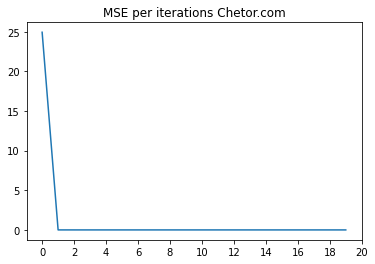

In [13]:
X = [i for i in range(20)]
plt.plot(X, MSEs)
plt.title("MSE per iterations " + WEB_SITE_NAME)
plt.xticks(np.arange(0, len(X)+1, 2))
plt.savefig(RESULTS + 'MSE_per_itrs1_' + WEB_SITE_NAME + '.png', dpi=400)

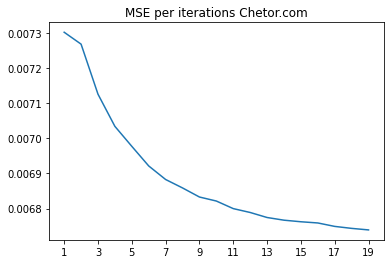

In [14]:
X = [i for i in range(1, 20)]
plt.plot(X, MSEs[1:])
plt.title("MSE per iterations " + WEB_SITE_NAME)
plt.xticks(np.arange(1, len(X)+1, 2))
plt.savefig(RESULTS + 'MSE_per_itrs2_' + WEB_SITE_NAME + '.png', dpi=400)

## Run on all

In [15]:
MSEs = []
visited3s = []
visited6s = []
hitRate3s = []
hitRate6s = []
AP3s = []
AP6s = []
trainingTime = []
qTime = []

In [16]:
visited3s1, visited6s1, hitRate3s1, hitRate6s1, AP3s1, AP6s1, trainingTime1, qTime1 = \
calc_visited_hitRate(alphas1, itrs1, factors1, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE1 = calc_mse__(alphas1, itrs1, factors1, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE1)
visited3s.append(visited3s1)
visited6s.append(visited6s1)
hitRate3s.append(hitRate3s1)
hitRate6s.append(hitRate6s1)
AP3s.append(AP3s1)
AP6s.append(AP6s1)
trainingTime.append(trainingTime1)
qTime.append(qTime1)

View matrix loaded in 7.1693174839019775 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 16.69174575805664 seconds.
test_shape (20988, 6877) train_shape (which we cant process bc of RAM) (212209, 6877)
total cells 50559 number of deleted cells 20988


/home/yektanet/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
94it [00:00, 937.87it/s]

test_shape (20988, 6877) train_shape (which we cant process bc of RAM) (212209, 6877)
total cells 50559 number of deleted cells 10111


50559it [01:03, 801.93it/s] 


------alphas, itrs, factors------ 0.1 15 5
ALS model is fitted in 0.5658423900604248 seconds.
annoy time: 1.3646256923675537
training and querry time: 0.5658423900604248 1.3646256923675537


  1%|▏         | 266/20988 [00:00<00:07, 2657.30it/s]

visited3s 0.0942939082278481


  1%|          | 222/20988 [00:00<00:09, 2211.74it/s]

visited6s 0.1216376582278481


  1%|          | 220/20988 [00:00<00:09, 2189.23it/s]

677 10111 0.06695677974483236
hitRate3s 0.06695677974483236


100%|██████████| 20988/20988 [00:10<00:00, 2077.73it/s]


851 10111 0.0841657600632974
hitRate6s 0.0841657600632974
ALS model is fitted in 0.651587724685669 seconds.


  1%|          | 158/20988 [00:00<00:13, 1578.58it/s]

1536 20988 0.07318467695826186
AP3s 0.07318467695826186


100%|██████████| 20988/20988 [00:13<00:00, 1585.79it/s]


1983 20988 0.09448256146369353
AP6s 0.09448256146369353
------alphas, itrs, factors------ 0.1 15 10
ALS model is fitted in 0.9211084842681885 seconds.
annoy time: 1.1187942028045654
training and querry time: 0.9211084842681885 1.1187942028045654


  1%|          | 254/20988 [00:00<00:08, 2534.26it/s]

visited3s 0.12386273734177215


  1%|          | 224/20988 [00:00<00:09, 2234.48it/s]

visited6s 0.16346914556962025


  0%|          | 0/20988 [00:00<?, ?it/s]

727 10111 0.0719018890317476
hitRate3s 0.0719018890317476


100%|██████████| 20988/20988 [00:09<00:00, 2129.82it/s]


959 10111 0.09484719612303431
hitRate6s 0.09484719612303431
ALS model is fitted in 0.8634750843048096 seconds.


  1%|          | 175/20988 [00:00<00:11, 1745.01it/s]

1687 20988 0.08037926434152849
AP3s 0.08037926434152849


100%|██████████| 20988/20988 [00:12<00:00, 1744.31it/s]


2341 20988 0.11153992757766343
AP6s 0.11153992757766343
------alphas, itrs, factors------ 0.1 15 20
ALS model is fitted in 1.3172171115875244 seconds.
annoy time: 0.924126386642456
training and querry time: 1.3172171115875244 0.924126386642456


  1%|▏         | 274/20988 [00:00<00:07, 2739.68it/s]

visited3s 0.17993473101265822


  1%|          | 231/20988 [00:00<00:08, 2308.71it/s]

visited6s 0.21499208860759494


  1%|          | 230/20988 [00:00<00:09, 2295.02it/s]

995 10111 0.0984076748096133
hitRate3s 0.0984076748096133


100%|██████████| 20988/20988 [00:09<00:00, 2228.92it/s]


1218 10111 0.12046286222925527
hitRate6s 0.12046286222925527
ALS model is fitted in 1.213602066040039 seconds.


  1%|          | 172/20988 [00:00<00:12, 1718.76it/s]

1640 20988 0.07813988946064418
AP3s 0.07813988946064418


100%|██████████| 20988/20988 [00:12<00:00, 1742.34it/s]


2170 20988 0.10339241471316943
AP6s 0.10339241471316943
------alphas, itrs, factors------ 0.1 15 40
ALS model is fitted in 8.213801860809326 seconds.
annoy time: 0.7956829071044922
training and querry time: 8.213801860809326 0.7956829071044922


  1%|▏         | 264/20988 [00:00<00:07, 2634.12it/s]

visited3s 0.24255834651898733


  1%|          | 234/20988 [00:00<00:08, 2337.19it/s]

visited6s 0.28357397151898733


  1%|          | 232/20988 [00:00<00:08, 2311.65it/s]

1024 10111 0.10127583819602413
hitRate3s 0.10127583819602413


100%|██████████| 20988/20988 [00:09<00:00, 2171.30it/s]


1315 10111 0.13005637424587083
hitRate6s 0.13005637424587083
ALS model is fitted in 9.008813381195068 seconds.


  1%|          | 139/20988 [00:00<00:15, 1384.54it/s]

1602 20988 0.07632933104631218
AP3s 0.07632933104631218


100%|██████████| 20988/20988 [00:13<00:00, 1527.79it/s]


2323 20988 0.1106822946445588
AP6s 0.1106822946445588
------alphas, itrs, factors------ 0.1 15 60
ALS model is fitted in 23.750150680541992 seconds.
annoy time: 0.8833417892456055
training and querry time: 23.750150680541992 0.8833417892456055


  0%|          | 0/20988 [00:00<?, ?it/s]

visited3s 0.28671380537974683


  1%|          | 177/20988 [00:00<00:11, 1763.85it/s]

visited6s 0.33183346518987344


  1%|          | 210/20988 [00:00<00:09, 2097.00it/s]

1096 10111 0.10839679556918208
hitRate3s 0.10839679556918208


100%|██████████| 20988/20988 [00:09<00:00, 2231.73it/s]


1425 10111 0.14093561467708438
hitRate6s 0.14093561467708438
ALS model is fitted in 22.641485452651978 seconds.


  1%|          | 180/20988 [00:00<00:11, 1793.55it/s]

1658 20988 0.07899752239374881
AP3s 0.07899752239374881


100%|██████████| 20988/20988 [00:13<00:00, 1578.53it/s]


2345 20988 0.1117305126739089
AP6s 0.1117305126739089
------alphas, itrs, factors------ 0.1 15 100
ALS model is fitted in 43.87515425682068 seconds.
annoy time: 0.7990026473999023
training and querry time: 43.87515425682068 0.7990026473999023


  0%|          | 0/20988 [00:00<?, ?it/s]

visited3s 0.34963409810126583


  1%|          | 219/20988 [00:00<00:09, 2187.84it/s]

visited6s 0.39668215981012656


  1%|          | 215/20988 [00:00<00:09, 2144.82it/s]

1130 10111 0.11175946988428444
hitRate3s 0.11175946988428444


100%|██████████| 20988/20988 [00:09<00:00, 2156.54it/s]


1459 10111 0.14429828899218672
hitRate6s 0.14429828899218672
ALS model is fitted in 42.41578555107117 seconds.


  1%|          | 168/20988 [00:00<00:12, 1678.55it/s]

1511 20988 0.07199352010672766
AP3s 0.07199352010672766


100%|██████████| 20988/20988 [00:12<00:00, 1668.92it/s]


2330 20988 0.11101581856298838
AP6s 0.11101581856298838
View matrix loaded in 6.841720342636108 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 16.979819297790527 seconds.
------alphas, itrs, factors: 0.1 15 5 ------
ALS model is fitted in 0.43859338760375977 seconds.
MSE 0.00044299005978022253
------alphas, itrs, factors: 0.1 15 10 ------
ALS model is fitted in 0.6699492931365967 seconds.
MSE 0.0004317594576638441
------alphas, itrs, factors: 0.1 15 20 ------
ALS model is fitted in 0.9587748050689697 seconds.
MSE 0.0004150898313080684
------alphas, itrs, factors: 0.1 15 40 ------
ALS model is fitted in 7.287027597427368 seconds.
MSE 0.0003913316

In [17]:
visited3s2, visited6s2, hitRate3s2, hitRate6s2, AP3s2, AP6s2, trainingTime2, qTime2 = \
calc_visited_hitRate(alphas2, itrs2, factors2, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE2 = calc_mse__(alphas2, itrs2, factors2, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE2)
visited3s.append(visited3s2)
visited6s.append(visited6s2)
hitRate3s.append(hitRate3s2)
hitRate6s.append(hitRate6s2)
AP3s.append(AP3s2)
AP6s.append(AP6s2)
trainingTime.append(trainingTime2)
qTime.append(qTime2)

View matrix loaded in 7.578397512435913 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 16.639718055725098 seconds.
test_shape (20988, 6877) train_shape (which we cant process bc of RAM) (212209, 6877)
total cells 50559 number of deleted cells 20988


111it [00:00, 1106.54it/s]

test_shape (20988, 6877) train_shape (which we cant process bc of RAM) (212209, 6877)
total cells 50559 number of deleted cells 10111


50559it [00:59, 851.07it/s] 


------alphas, itrs, factors------ 10 15 5
ALS model is fitted in 0.5703403949737549 seconds.
annoy time: 0.9002330303192139
training and querry time: 0.5703403949737549 0.9002330303192139


  1%|          | 252/20988 [00:00<00:08, 2511.59it/s]

visited3s 0.17627571202531644


  1%|          | 183/20988 [00:00<00:11, 1825.61it/s]

visited6s 0.22517800632911392


  1%|          | 206/20988 [00:00<00:10, 2059.38it/s]

1219 10111 0.12056176441499357
hitRate3s 0.12056176441499357


100%|██████████| 20988/20988 [00:10<00:00, 1977.19it/s]


1605 10111 0.15873800810997923
hitRate6s 0.15873800810997923
ALS model is fitted in 0.6431443691253662 seconds.


  1%|          | 159/20988 [00:00<00:13, 1582.82it/s]

2095 20988 0.0998189441585668
AP3s 0.0998189441585668


100%|██████████| 20988/20988 [00:12<00:00, 1638.40it/s]


2942 20988 0.14017533828854584
AP6s 0.14017533828854584
------alphas, itrs, factors------ 10 15 10
ALS model is fitted in 0.890251636505127 seconds.
annoy time: 0.683079719543457
training and querry time: 0.890251636505127 0.683079719543457


  1%|          | 237/20988 [00:00<00:08, 2369.84it/s]

visited3s 0.23711926424050633


  1%|          | 214/20988 [00:00<00:09, 2134.64it/s]

visited6s 0.31395866297468356


  0%|          | 0/20988 [00:00<?, ?it/s]

1509 10111 0.14924339827910196
hitRate3s 0.14924339827910196


100%|██████████| 20988/20988 [00:09<00:00, 2122.13it/s]


1930 10111 0.19088121847492828
hitRate6s 0.19088121847492828
ALS model is fitted in 0.8748421669006348 seconds.


  1%|          | 164/20988 [00:00<00:12, 1637.50it/s]

2791 20988 0.1329807509052792
AP3s 0.1329807509052792


100%|██████████| 20988/20988 [00:12<00:00, 1654.56it/s]


3753 20988 0.17881646655231562
AP6s 0.17881646655231562
------alphas, itrs, factors------ 10 15 20
ALS model is fitted in 1.3134839534759521 seconds.
annoy time: 0.5316600799560547
training and querry time: 1.3134839534759521 0.5316600799560547


  1%|          | 252/20988 [00:00<00:08, 2518.46it/s]

visited3s 0.3552462420886076


  1%|          | 209/20988 [00:00<00:09, 2088.32it/s]

visited6s 0.43245648734177217


  1%|          | 204/20988 [00:00<00:10, 2034.34it/s]

1865 10111 0.1844525764019385
hitRate3s 0.1844525764019385


100%|██████████| 20988/20988 [00:09<00:00, 2117.71it/s]


2371 10111 0.23449708238552072
hitRate6s 0.23449708238552072
ALS model is fitted in 1.2610924243927002 seconds.


  1%|          | 133/20988 [00:00<00:15, 1329.19it/s]

3241 20988 0.154421574232895
AP3s 0.154421574232895


100%|██████████| 20988/20988 [00:13<00:00, 1589.80it/s]


4384 20988 0.20888126548503907
AP6s 0.20888126548503907
------alphas, itrs, factors------ 10 15 40
ALS model is fitted in 8.59513521194458 seconds.
annoy time: 0.6670880317687988
training and querry time: 8.59513521194458 0.6670880317687988


  1%|▏         | 263/20988 [00:00<00:07, 2620.99it/s]

visited3s 0.4720628955696203


  1%|          | 225/20988 [00:00<00:09, 2246.84it/s]

visited6s 0.5745401503164557


  1%|          | 218/20988 [00:00<00:09, 2174.48it/s]

2114 10111 0.2090792206507764
hitRate3s 0.2090792206507764


100%|██████████| 20988/20988 [00:10<00:00, 2017.48it/s]


2685 10111 0.26555236870734844
hitRate6s 0.26555236870734844
ALS model is fitted in 14.255520582199097 seconds.


  1%|          | 163/20988 [00:00<00:12, 1621.39it/s]

3407 20988 0.16233085572708214
AP3s 0.16233085572708214


100%|██████████| 20988/20988 [00:13<00:00, 1538.13it/s]


4757 20988 0.2266533257099295
AP6s 0.2266533257099295
------alphas, itrs, factors------ 10 15 60
ALS model is fitted in 14.895954608917236 seconds.
annoy time: 0.7620086669921875
training and querry time: 14.895954608917236 0.7620086669921875


  1%|▏         | 265/20988 [00:00<00:07, 2641.05it/s]

visited3s 0.5524376977848101


  1%|          | 212/20988 [00:00<00:09, 2110.74it/s]

visited6s 0.6591920490506329


  0%|          | 0/20988 [00:00<?, ?it/s]

2197 10111 0.21728810206705568
hitRate3s 0.21728810206705568


100%|██████████| 20988/20988 [00:10<00:00, 2051.54it/s]


2822 10111 0.2791019681534962
hitRate6s 0.2791019681534962
ALS model is fitted in 15.071038007736206 seconds.


  1%|          | 127/20988 [00:00<00:16, 1267.16it/s]

3216 20988 0.15323041738136078
AP3s 0.15323041738136078


100%|██████████| 20988/20988 [00:13<00:00, 1573.82it/s]


4769 20988 0.2272250809986659
AP6s 0.2272250809986659
------alphas, itrs, factors------ 10 15 100
ALS model is fitted in 44.270195722579956 seconds.
annoy time: 0.723621129989624
training and querry time: 44.270195722579956 0.723621129989624


  1%|▏         | 265/20988 [00:00<00:07, 2642.02it/s]

visited3s 0.6611204509493671


  1%|          | 227/20988 [00:00<00:09, 2264.49it/s]

visited6s 0.7658227848101266


  1%|          | 217/20988 [00:00<00:09, 2162.27it/s]

2190 10111 0.21659578676688754
hitRate3s 0.21659578676688754


100%|██████████| 20988/20988 [00:11<00:00, 1883.54it/s]


2887 10111 0.285530610226486
hitRate6s 0.285530610226486
ALS model is fitted in 66.63395404815674 seconds.


  1%|          | 115/20988 [00:00<00:18, 1144.97it/s]

2781 20988 0.13250428816466553
AP3s 0.13250428816466553


100%|██████████| 20988/20988 [00:15<00:00, 1318.98it/s]


4206 20988 0.2004002287021155
AP6s 0.2004002287021155
View matrix loaded in 7.762320041656494 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 18.792057037353516 seconds.
------alphas, itrs, factors: 10 15 5 ------
ALS model is fitted in 0.4329049587249756 seconds.
MSE 0.0007069327906809673
------alphas, itrs, factors: 10 15 10 ------
ALS model is fitted in 0.8028178215026855 seconds.
MSE 0.0007709027931198582
------alphas, itrs, factors: 10 15 20 ------
ALS model is fitted in 1.1875836849212646 seconds.
MSE 0.0008313887178644597
------alphas, itrs, factors: 10 15 40 ------
ALS model is fitted in 10.573253154754639 seconds.
MSE 0.00086761846385908

In [18]:
visited3s3, visited6s3, hitRate3s3, hitRate6s3, AP3s3, AP6s3, trainingTime3, qTime3 = \
calc_visited_hitRate(alphas3, itrs3, factors3, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE3 = calc_mse__(alphas3, itrs3, factors3, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE3)
visited3s.append(visited3s3)
visited6s.append(visited6s3)
hitRate3s.append(hitRate3s3)
hitRate6s.append(hitRate6s3)
AP3s.append(AP3s3)
AP6s.append(AP6s3)
trainingTime.append(trainingTime3)
qTime.append(qTime3)

View matrix loaded in 8.338136434555054 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 18.430848360061646 seconds.
test_shape (20988, 6877) train_shape (which we cant process bc of RAM) (212209, 6877)
total cells 50559 number of deleted cells 20988


71it [00:00, 706.28it/s]

test_shape (20988, 6877) train_shape (which we cant process bc of RAM) (212209, 6877)
total cells 50559 number of deleted cells 10111


50559it [01:02, 811.83it/s] 


------alphas, itrs, factors------ 100 15 5
ALS model is fitted in 0.5713295936584473 seconds.
annoy time: 0.9749841690063477
training and querry time: 0.5713295936584473 0.9749841690063477


  1%|          | 248/20988 [00:00<00:08, 2473.59it/s]

visited3s 0.1870549841772152


  1%|          | 219/20988 [00:00<00:09, 2187.57it/s]

visited6s 0.26115011867088606


  1%|          | 220/20988 [00:00<00:09, 2194.86it/s]

1169 10111 0.11561665512807832
hitRate3s 0.11561665512807832


100%|██████████| 20988/20988 [00:09<00:00, 2135.30it/s]


1581 10111 0.15636435565225992
hitRate6s 0.15636435565225992
ALS model is fitted in 0.645714282989502 seconds.


  1%|          | 163/20988 [00:00<00:12, 1627.03it/s]

1297 20988 0.06179721745759482
AP3s 0.06179721745759482


100%|██████████| 20988/20988 [00:13<00:00, 1600.79it/s]


2026 20988 0.09653135124833238
AP6s 0.09653135124833238
------alphas, itrs, factors------ 100 15 10
ALS model is fitted in 0.9253954887390137 seconds.
annoy time: 0.8797273635864258
training and querry time: 0.9253954887390137 0.8797273635864258


  1%|          | 250/20988 [00:00<00:08, 2497.29it/s]

visited3s 0.3161590189873418


  1%|          | 207/20988 [00:00<00:10, 2064.32it/s]

visited6s 0.4189082278481013


  1%|          | 226/20988 [00:00<00:09, 2250.01it/s]

1694 10111 0.16754030264068837
hitRate3s 0.16754030264068837


100%|██████████| 20988/20988 [00:10<00:00, 2074.12it/s]


2213 10111 0.21887053703886855
hitRate6s 0.21887053703886855
ALS model is fitted in 0.8732974529266357 seconds.


  1%|          | 163/20988 [00:00<00:12, 1624.73it/s]

2493 20988 0.11878216123499143
AP3s 0.11878216123499143


100%|██████████| 20988/20988 [00:13<00:00, 1526.45it/s]


3548 20988 0.1690489803697351
AP6s 0.1690489803697351
------alphas, itrs, factors------ 100 15 20
ALS model is fitted in 1.4736685752868652 seconds.
annoy time: 0.861138105392456
training and querry time: 1.4736685752868652 0.861138105392456


  1%|          | 253/20988 [00:00<00:08, 2529.03it/s]

visited3s 0.46269284018987344


  1%|          | 199/20988 [00:00<00:10, 1985.89it/s]

visited6s 0.6041337025316456


  1%|          | 215/20988 [00:00<00:09, 2133.81it/s]

2036 10111 0.2013648501631886
hitRate3s 0.2013648501631886


100%|██████████| 20988/20988 [00:10<00:00, 2086.67it/s]


2630 10111 0.26011274849174165
hitRate6s 0.26011274849174165
ALS model is fitted in 1.3858215808868408 seconds.


  1%|          | 151/20988 [00:00<00:13, 1507.12it/s]

2691 20988 0.12821612349914235
AP3s 0.12821612349914235


100%|██████████| 20988/20988 [00:13<00:00, 1567.83it/s]


3994 20988 0.19029921860110538
AP6s 0.19029921860110538
------alphas, itrs, factors------ 100 15 40
ALS model is fitted in 9.755054950714111 seconds.
annoy time: 0.7090508937835693
training and querry time: 9.755054950714111 0.7090508937835693


  1%|▏         | 268/20988 [00:00<00:07, 2678.15it/s]

visited3s 0.6579558939873418


  1%|          | 196/20988 [00:00<00:10, 1958.62it/s]

visited6s 0.8103243670886076


  0%|          | 0/20988 [00:00<?, ?it/s]

2274 10111 0.22490357036890515
hitRate3s 0.22490357036890515


100%|██████████| 20988/20988 [00:10<00:00, 1991.78it/s]


2950 10111 0.2917614479279992
hitRate6s 0.2917614479279992
ALS model is fitted in 11.442795038223267 seconds.


  2%|▏         | 343/20988 [00:00<00:12, 1714.41it/s]

3133 20988 0.1492757766342672
AP3s 0.1492757766342672


100%|██████████| 20988/20988 [00:12<00:00, 1647.16it/s]


4601 20988 0.219220506956356
AP6s 0.219220506956356
------alphas, itrs, factors------ 100 15 60
ALS model is fitted in 18.689983367919922 seconds.
annoy time: 0.6860911846160889
training and querry time: 18.689983367919922 0.6860911846160889


  1%|          | 239/20988 [00:00<00:08, 2381.46it/s]

visited3s 0.7622379351265823


  1%|          | 214/20988 [00:00<00:09, 2136.20it/s]

visited6s 0.8902788765822784


  1%|          | 193/20988 [00:00<00:10, 1920.60it/s]

2336 10111 0.23103550588468005
hitRate3s 0.23103550588468005


100%|██████████| 20988/20988 [00:10<00:00, 2034.97it/s]


3026 10111 0.29927801404411036
hitRate6s 0.29927801404411036
ALS model is fitted in 17.17758321762085 seconds.


  1%|          | 168/20988 [00:00<00:12, 1676.56it/s]

3091 20988 0.14727463312368974
AP3s 0.14727463312368974


100%|██████████| 20988/20988 [00:13<00:00, 1598.33it/s]


4737 20988 0.2257004002287021
AP6s 0.2257004002287021
------alphas, itrs, factors------ 100 15 100
ALS model is fitted in 89.01523947715759 seconds.
annoy time: 0.9631435871124268
training and querry time: 89.01523947715759 0.9631435871124268


  0%|          | 0/20988 [00:00<?, ?it/s]

visited3s 0.8573229825949367


  0%|          | 0/20988 [00:00<?, ?it/s]

visited6s 0.9495648734177216


  0%|          | 0/20988 [00:00<?, ?it/s]

2342 10111 0.23162891899910987
hitRate3s 0.23162891899910987


100%|██████████| 20988/20988 [00:12<00:00, 1632.43it/s]


3028 10111 0.29947581841558696
hitRate6s 0.29947581841558696
ALS model is fitted in 80.39102959632874 seconds.


  0%|          | 103/20988 [00:00<00:20, 1029.33it/s]

2998 20988 0.14284352963598246
AP3s 0.14284352963598246


100%|██████████| 20988/20988 [00:17<00:00, 1169.00it/s]


4668 20988 0.2224128073184677
AP6s 0.2224128073184677
View matrix loaded in 7.579580307006836 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 19.974650621414185 seconds.
------alphas, itrs, factors: 100 15 5 ------
ALS model is fitted in 0.4611480236053467 seconds.
MSE 0.007495649893183082
------alphas, itrs, factors: 100 15 10 ------
ALS model is fitted in 0.8180780410766602 seconds.
MSE 0.007698521621197013
------alphas, itrs, factors: 100 15 20 ------
ALS model is fitted in 1.2704510688781738 seconds.
MSE 0.007056010561124149
------alphas, itrs, factors: 100 15 40 ------
ALS model is fitted in 17.87020468711853 seconds.
MSE 0.00563698038085122

In [19]:
visited3s4, visited6s4, hitRate3s4, hitRate6s4, AP3s4, AP6s4, trainingTime4, qTime4 = \
calc_visited_hitRate(alphas4, itrs4, factors4, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE4 = calc_mse__(alphas4, itrs4, factors4, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE4)
visited3s.append(visited3s4)
visited6s.append(visited6s4)
hitRate3s.append(hitRate3s4)
hitRate6s.append(hitRate6s4)
AP3s.append(AP3s4)
AP6s.append(AP6s4)
trainingTime.append(trainingTime4)
qTime.append(qTime4)

View matrix loaded in 8.403518199920654 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 17.978147983551025 seconds.
test_shape (20988, 6877) train_shape (which we cant process bc of RAM) (212209, 6877)
total cells 50559 number of deleted cells 20988


95it [00:00, 946.57it/s]

test_shape (20988, 6877) train_shape (which we cant process bc of RAM) (212209, 6877)
total cells 50559 number of deleted cells 10111


50559it [01:20, 624.84it/s]


------alphas, itrs, factors------ 1000 15 5
ALS model is fitted in 0.5632808208465576 seconds.
annoy time: 0.9784626960754395
training and querry time: 0.5632808208465576 0.9784626960754395


  1%|          | 256/20988 [00:00<00:08, 2558.40it/s]

visited3s 0.1553846914556962


  1%|          | 195/20988 [00:00<00:10, 1945.61it/s]

visited6s 0.23889932753164558


  0%|          | 0/20988 [00:00<?, ?it/s]

835 10111 0.08258332509148453
hitRate3s 0.08258332509148453


100%|██████████| 20988/20988 [00:10<00:00, 1910.03it/s]


1189 10111 0.11759469884284443
hitRate6s 0.11759469884284443
ALS model is fitted in 0.6756405830383301 seconds.


  1%|          | 147/20988 [00:00<00:14, 1462.38it/s]

735 20988 0.035020011435105775
AP3s 0.035020011435105775


100%|██████████| 20988/20988 [00:14<00:00, 1465.95it/s]


1174 20988 0.0559367257480465
AP6s 0.0559367257480465
------alphas, itrs, factors------ 1000 15 10
ALS model is fitted in 1.013364553451538 seconds.
annoy time: 0.9509046077728271
training and querry time: 1.013364553451538 0.9509046077728271


  0%|          | 0/20988 [00:00<?, ?it/s]

visited3s 0.33324268196202533


  0%|          | 0/20988 [00:00<?, ?it/s]

visited6s 0.48066653481012656


  0%|          | 0/20988 [00:00<?, ?it/s]

1294 10111 0.12797942834536644
hitRate3s 0.12797942834536644


100%|██████████| 20988/20988 [00:12<00:00, 1681.30it/s]


1822 10111 0.18019978241519138
hitRate6s 0.18019978241519138
ALS model is fitted in 1.0978548526763916 seconds.


  1%|          | 123/20988 [00:00<00:17, 1222.87it/s]

768 20988 0.03659233847913093
AP3s 0.03659233847913093


100%|██████████| 20988/20988 [00:16<00:00, 1243.13it/s]


1480 20988 0.07051648561082523
AP6s 0.07051648561082523
------alphas, itrs, factors------ 1000 15 20
ALS model is fitted in 1.6078946590423584 seconds.
annoy time: 0.8333644866943359
training and querry time: 1.6078946590423584 0.8333644866943359


  1%|          | 220/20988 [00:00<00:09, 2194.84it/s]

visited3s 0.6170886075949367


  1%|          | 184/20988 [00:00<00:11, 1832.31it/s]

visited6s 0.7885433148734177


  0%|          | 0/20988 [00:00<?, ?it/s]

1810 10111 0.17901295618633173
hitRate3s 0.17901295618633173


100%|██████████| 20988/20988 [00:12<00:00, 1664.78it/s]


2428 10111 0.2401345069726041
hitRate6s 0.2401345069726041
ALS model is fitted in 1.4718456268310547 seconds.


  1%|          | 125/20988 [00:00<00:16, 1247.80it/s]

1405 20988 0.0669430150562226
AP3s 0.0669430150562226


100%|██████████| 20988/20988 [00:17<00:00, 1217.15it/s]


2456 20988 0.11701924909472079
AP6s 0.11701924909472079
------alphas, itrs, factors------ 1000 15 40
ALS model is fitted in 18.414348363876343 seconds.
annoy time: 0.7935266494750977
training and querry time: 18.414348363876343 0.7935266494750977


  0%|          | 0/20988 [00:00<?, ?it/s]

visited3s 0.8487193433544303


  0%|          | 0/20988 [00:00<?, ?it/s]

visited6s 0.9424940664556962


  0%|          | 0/20988 [00:00<?, ?it/s]

2185 10111 0.21610127583819602
hitRate3s 0.21610127583819602


100%|██████████| 20988/20988 [00:12<00:00, 1675.48it/s]


2817 10111 0.2786074572248047
hitRate6s 0.2786074572248047
ALS model is fitted in 16.693392276763916 seconds.


  1%|          | 111/20988 [00:00<00:18, 1105.19it/s]

1809 20988 0.08619210977701544
AP3s 0.08619210977701544


100%|██████████| 20988/20988 [00:17<00:00, 1234.21it/s]


2915 20988 0.1388888888888889
AP6s 0.1388888888888889
------alphas, itrs, factors------ 1000 15 60
ALS model is fitted in 30.41751480102539 seconds.
annoy time: 0.8604471683502197
training and querry time: 30.41751480102539 0.8604471683502197


  1%|          | 211/20988 [00:00<00:09, 2105.67it/s]

visited3s 0.8954707278481012


  0%|          | 0/20988 [00:00<?, ?it/s]

visited6s 0.9623714398734177


  0%|          | 0/20988 [00:00<?, ?it/s]

2257 10111 0.22322223321135398
hitRate3s 0.22322223321135398


100%|██████████| 20988/20988 [00:12<00:00, 1694.16it/s]


2877 10111 0.284541588369103
hitRate6s 0.284541588369103
ALS model is fitted in 23.00267720222473 seconds.


  0%|          | 103/20988 [00:00<00:20, 1026.92it/s]

2139 20988 0.10191538021726701
AP3s 0.10191538021726701


100%|██████████| 20988/20988 [00:18<00:00, 1110.46it/s]


3431 20988 0.16347436630455497
AP6s 0.16347436630455497
------alphas, itrs, factors------ 1000 15 100
ALS model is fitted in 59.409804821014404 seconds.
annoy time: 0.7883932590484619
training and querry time: 59.409804821014404 0.7883932590484619


  1%|          | 250/20988 [00:00<00:08, 2494.55it/s]

visited3s 0.916707871835443


  1%|          | 199/20988 [00:00<00:10, 1986.42it/s]

visited6s 0.9711975870253164


  1%|          | 206/20988 [00:00<00:10, 2053.54it/s]

2253 10111 0.22282662446840076
hitRate3s 0.22282662446840076


100%|██████████| 20988/20988 [00:10<00:00, 2006.58it/s]


2900 10111 0.28681633864108397
hitRate6s 0.28681633864108397
ALS model is fitted in 51.50571966171265 seconds.


  1%|          | 154/20988 [00:00<00:13, 1536.63it/s]

2525 20988 0.12030684200495521
AP3s 0.12030684200495521


100%|██████████| 20988/20988 [00:13<00:00, 1578.90it/s]


3841 20988 0.18300933866971603
AP6s 0.18300933866971603
View matrix loaded in 7.553820371627808 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 18.3766930103302 seconds.
------alphas, itrs, factors: 1000 15 5 ------
ALS model is fitted in 0.42946791648864746 seconds.
MSE 0.05019282782112994
------alphas, itrs, factors: 1000 15 10 ------
ALS model is fitted in 0.6528868675231934 seconds.
MSE 0.034619483589082616
------alphas, itrs, factors: 1000 15 20 ------
ALS model is fitted in 1.16206693649292 seconds.
MSE 0.02120167970294561
------alphas, itrs, factors: 1000 15 40 ------
ALS model is fitted in 9.498015403747559 seconds.
MSE 0.0119159194007141

In [22]:
MSEs = np.array(MSEs).reshape(24)
visited3s = np.array(visited3s).reshape(24)
visited6s = np.array(visited6s).reshape(24)
hitRate3s = np.array(hitRate3s).reshape(24)
hitRate6s = np.array(hitRate6s).reshape(24)
AP3s = np.array(AP3s).reshape(24)
AP6s = np.array(AP6s).reshape(24)
trainingTime = np.array(trainingTime).reshape(24)
qTime = np.array(qTime).reshape(24)

In [24]:
len(trainingTime)

24

In [26]:
import prettytable
x = prettytable.PrettyTable(["Hyperparameters", "MSE", "Visited@6", "Visited@3", "HitRate@6", "HitRate@3", "AP@6", "AP@3"])
for i in range(24):
    x.add_row([str('alpha:' + str(alphas[i]) + ', factors:' + str(factors[i])), round(MSEs[i], 7), round(visited6s[i], 4), round(visited3s[i], 4), round(hitRate6s[i], 4), round(hitRate3s[i], 4), round(AP6s[i], 4), round(AP3s[i], 4)])
y = prettytable.PrettyTable(["Hyperparameters", "MSE", "Query time", 'Training Time'])
for i in range(24):
    y.add_row([str('alpha:' + str(alphas[i]) + ', factors:' + str(factors[i])), round(MSEs[i], 7), round(qTime[i], 4), round(trainingTime[i], 4)])

In [30]:
print("iterations: 15")
print(x)
print(y)
data = x.get_string()
with open(RESULTS + 'ALSacc_hyperparameters_' + WEB_SITE_NAME + '.txt', 'w') as f:
    f.write(data)
data = y.get_string()
with open(RESULTS + 'ALStime_hyperparameters_' + WEB_SITE_NAME + '.txt', 'w') as f:
    f.write(data)

iterations: 15
+-------------------------+-----------+-----------+-----------+-----------+-----------+--------+--------+
|     Hyperparameters     |    MSE    | Visited@6 | Visited@3 | HitRate@6 | HitRate@3 |  AP@6  |  AP@3  |
+-------------------------+-----------+-----------+-----------+-----------+-----------+--------+--------+
|   alpha:0.1, factors:5  |  0.000443 |   0.1216  |   0.0943  |   0.0842  |   0.067   | 0.0945 | 0.0732 |
|  alpha:0.1, factors:10  | 0.0004318 |   0.1635  |   0.1239  |   0.0948  |   0.0719  | 0.1115 | 0.0804 |
|  alpha:0.1, factors:20  | 0.0004151 |   0.215   |   0.1799  |   0.1205  |   0.0984  | 0.1034 | 0.0781 |
|  alpha:0.1, factors:40  | 0.0003913 |   0.2836  |   0.2426  |   0.1301  |   0.1013  | 0.1107 | 0.0763 |
|  alpha:0.1, factors:60  | 0.0003712 |   0.3318  |   0.2867  |   0.1409  |   0.1084  | 0.1117 | 0.079  |
|  alpha:0.1, factors:100 | 0.0003394 |   0.3967  |   0.3496  |   0.1443  |   0.1118  | 0.111  | 0.072  |
|   alpha:10, factors:5   | 0.0

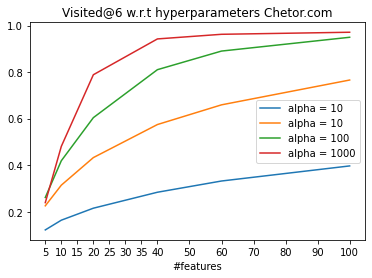

In [32]:
plt.plot(factors[:6], visited6s[:6], label='alpha = 10')
plt.plot(factors[6:12], visited6s[6:12], label='alpha = 10')
plt.plot(factors[12:18], visited6s[12:18], label='alpha = 100')
plt.plot(factors[18:24], visited6s[18:24], label='alpha = 1000')
plt.title("Visited@6 w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'visited@6_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

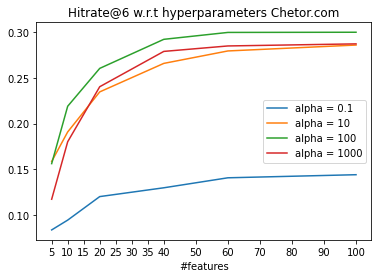

In [34]:
plt.plot(factors[:6], hitRate6s[:6], label='alpha = 0.1')
plt.plot(factors[6:12], hitRate6s[6:12], label='alpha = 10')
plt.plot(factors[12:18], hitRate6s[12:18], label='alpha = 100')
plt.plot(factors[18:24], hitRate6s[18:24], label='alpha = 1000')
plt.title("Hitrate@6 w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'hitrate@6_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

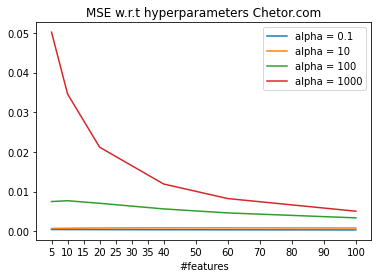

In [35]:
plt.plot(factors[:6], MSEs[:6], label='alpha = 0.1')
plt.plot(factors[6:12], MSEs[6:12], label='alpha = 10')
plt.plot(factors[12:18], MSEs[12:18], label='alpha = 100')
plt.plot(factors[18:24], MSEs[18:24], label='alpha = 1000')
plt.title("MSE w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'MSE_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

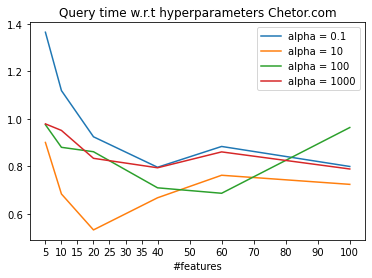

In [36]:
plt.plot(factors[:6], qTime[:6], label='alpha = 0.1')
plt.plot(factors[6:12], qTime[6:12], label='alpha = 10')
plt.plot(factors[12:18], qTime[12:18], label='alpha = 100')
plt.plot(factors[18:24], qTime[18:24], label='alpha = 1000')
plt.title("Query time w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'querytime_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

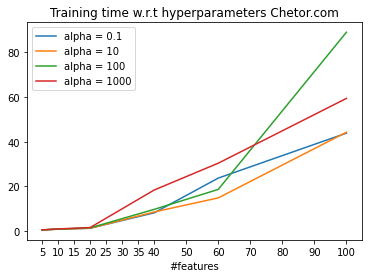

In [38]:
plt.plot(factors[:6], trainingTime[:6], label='alpha = 0.1')
plt.plot(factors[6:12], trainingTime[6:12], label='alpha = 10')
plt.plot(factors[12:18], trainingTime[12:18], label='alpha = 100')
plt.plot(factors[18:24], trainingTime[18:24], label='alpha = 1000')
plt.title("Training time w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'trainingtime_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)